In [1]:
# Run only if you need to cold start 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Repositories/TCN_TimeGAN_Repo

/content/gdrive/MyDrive/Repositories/TCN_TimeGAN_Repo


In [118]:
%cd ../

/content/gdrive/MyDrive/Repositories


# Imports

In [3]:
from matplotlib.ticker import FuncFormatter

from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (GRU, Dense) 
from tensorflow.keras.optimizers import Adam
                                     
import os, time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_style('white')

# Parameters

In [4]:
from src.params_08 import (experiment, 
                                      ## Data Parameters
                                      data_file,
                                      ts_names,
                                      start_date,
                                      end_date,                                                                            
                                       
                                      ## Training Parameters
                                      n_seq,
                                      seq_len,
                                      batch_size)                                       

# Experiment Path

In [5]:
results_path = Path('./')
log_dir = results_path / f'experiment_{experiment:02}'
evals_dir = log_dir / 'evals'
sample_dir = log_dir / 'samples'
hdf_store = log_dir / f'TimeSeriesGAN_{experiment:02}.h5'

# Load Real and Synthetic Data

## Load Real Data

In [6]:
tickers = ts_names

In [7]:
%pwd

'/content/gdrive/MyDrive/Repositories/TCN_TimeGAN_Repo'

In [8]:
import datetime as dt

df = pd.read_hdf(hdf_store, 'data/real')
start = dt.datetime(*start_date)
end = dt.datetime(*end_date)
#df = df.set_index(['date'])     # use DateTime index

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4528 entries, 2000-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Adj Close, BA)   4528 non-null   float64
 1   (Adj Close, CAT)  4528 non-null   float64
 2   (Adj Close, DIS)  4528 non-null   float64
 3   (Adj Close, GE)   4528 non-null   float64
 4   (Adj Close, IBM)  4528 non-null   float64
 5   (Adj Close, KO)   4528 non-null   float64
dtypes: float64(6)
memory usage: 247.6 KB


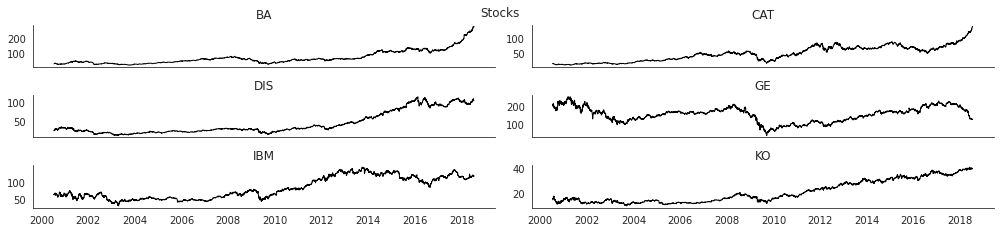

In [10]:
axes = df.loc[start:end].plot(subplots=True,
                                        figsize=(14, 6),
                                        layout=(n_seq, 2),
                                        title=tickers,
                                        legend=False,
                                        rot=0,
                                        lw=1, 
                                        color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Stocks')
plt.gcf().tight_layout()
sns.despine();

## Normalize Real Data

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


## Create rolling window sequences

In [12]:
data = []
for i in range(len(df)-seq_len): 
  data.append(scaled_data[i:i + seq_len])

real_data = np.stack(data)
real_data.shape

(4348, 180, 6)

## Load Synthetic Data

In [13]:
synthetic_data = np.load(results_path / f'experiment_{experiment:02d}' / 'generated_data.npy')
synthetic_data.shape

(4096, 180, 6)

# Prepare Sample

In [14]:
sample_size = 1000
idx_r = np.random.permutation(len(real_data))[:sample_size]
idx_s = np.random.permutation(len(synthetic_data))[:sample_size]

In [15]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx_r]
synthetic_sample = np.asarray(synthetic_data)[idx_s]

In [16]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [17]:
real_sample_2d.shape, synthetic_sample_2d.shape

((6000, 180), (6000, 180))

# Visualization in 2D: A Qualitative Assessment of Diversity

## Run PCA

In [18]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

## Run t-SNE

In [19]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.002s...
[t-SNE] Computed neighbors for 12000 samples in 3.381s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.152390
[t-SNE] KL divergenc

In [20]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

## Plot Result

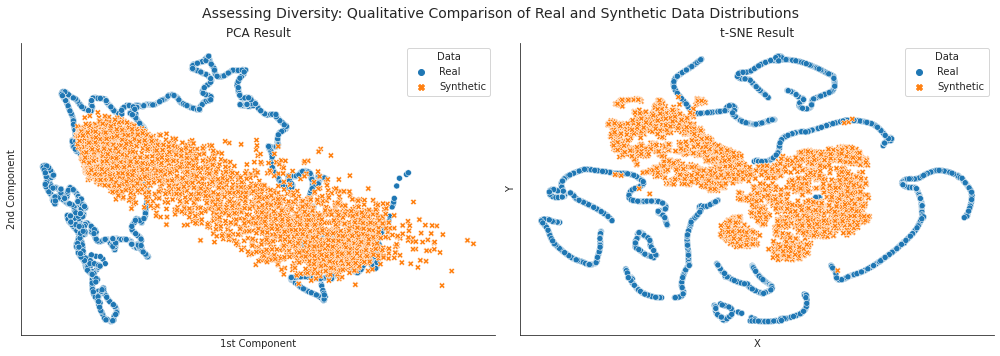

In [21]:
sample_num = 9

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);
f_name = os.path.join(log_dir, "evals", "distrib_sample_" + str(sample_num) + ".png")
fig.savefig(f_name)

# Time Series Classification: A quantitative Assessment of Fidelity

## Prepare Data

In [22]:
n_series = len(synthetic_data)
real_data_s = real_data[:n_series, :, :]

In [23]:
idx = np.arange(n_series)

In [24]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [25]:
train_data = np.vstack((real_data_s[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data_s[test_idx], 
                       synthetic_data[test_idx]))

In [26]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

In [27]:
[n_train, n_test]

[3276, 820]

## Create Classifier

In [28]:
ts_classifier = Sequential([GRU(6, input_shape=(seq_len, n_seq), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [29]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [30]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 6)                 252       
                                                                 
 OUT (Dense)                 (None, 1)                 7         
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


In [31]:
epochs = 100
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=epochs,
                           batch_size=batch_size,
                           verbose=0)

In [32]:
ts_classifier.evaluate(x=test_data, y=test_labels)

52/52 [==============================] - 0s 5ms/step - loss: 4.6883 - AUC: 0.5159 - accuracy: 0.5134


[4.688258171081543, 0.5158536434173584, 0.5134146213531494]

In [33]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          100 non-null    float64
 1   AUC           100 non-null    float64
 2   accuracy      100 non-null    float64
 3   val_loss      100 non-null    float64
 4   val_AUC       100 non-null    float64
 5   val_accuracy  100 non-null    float64
dtypes: float64(6)
memory usage: 4.8 KB


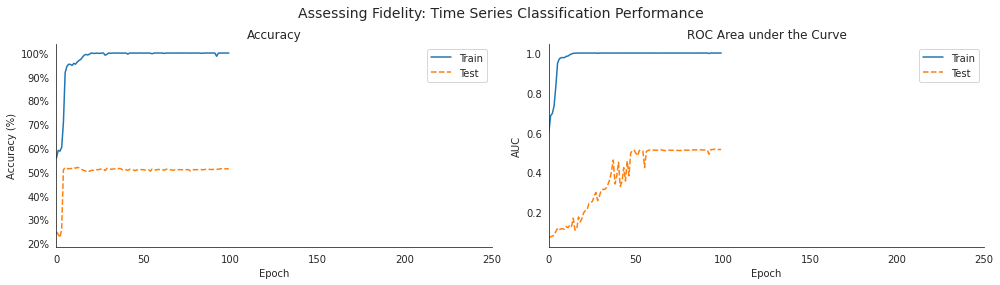

In [34]:
sample_num = 7

sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);
f_name = os.path.join(log_dir, "evals", "classify_sample_" + str(sample_num) + ".png")
fig.savefig(f_name)

# Train on Synthetic, test on real: Assessing usefulness

In [35]:
real_data_s.shape, synthetic_data.shape

((4096, 180, 6), (4096, 180, 6))

In [36]:
real_train_data = real_data_s[train_idx, :seq_len-1, :]
real_train_label = real_data_s[train_idx, -1, :]

real_test_data = real_data_s[test_idx, :seq_len-1, :]
real_test_label = real_data_s[test_idx, -1, :]

In [37]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((3276, 179, 6), (3276, 6), (820, 179, 6), (820, 6))

In [38]:
synthetic_train = synthetic_data[train_idx, :seq_len-1, :]
synthetic_label = synthetic_data[train_idx, -1, :]

In [39]:
synthetic_train.shape, synthetic_label.shape

((3276, 179, 6), (3276, 6))

In [40]:
def get_model():
    model = Sequential([GRU(12, input_shape=(seq_len-1, n_seq)),
                        Dense(6)])

    model.compile(optimizer=Adam(),
                  loss='MeanAbsoluteError')
                  #(name='MAE'))
    return model

In [41]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [42]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [43]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

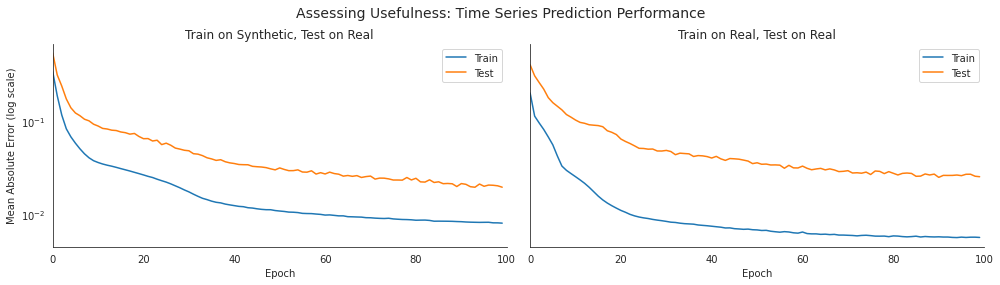

In [44]:
sample_num = 9

sns.set_style('white')

fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);
f_name = os.path.join(log_dir, "evals", "TSTR_sample_" + str(sample_num) + ".png")
fig.savefig(f_name)